In [1]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit
import scipy.signal

In [2]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [3]:
def rebin_histogram(bins, counts, new_bin_size):
    """Rebin a histogram to a new bin size.
    Parameters:
        bins (np.ndarray): The bin edges of the histogram.
        counts (np.ndarray): The number of counts in each bin.
        new_bin_size (float): The size of the new bins.
    Returns:
        np.ndarray: The new bin edges.
        np.ndarray: The new bin counts.
    """
    # Find the new number of bins
    new_nbins = int((bins[-1] - bins[0]) / new_bin_size)
    # Create the new bin edges
    new_bins = np.linspace(bins[0], bins[-1], new_nbins + 1)
    # Digitize the original bins into the new bins
    digitized_bins = np.digitize(bins, new_bins)
    # Calculate the new counts
    new_counts = np.array([counts[digitized_bins == i].sum() for i in range(1, new_nbins + 1)])

    new_centers = new_bins[:-1] + np.diff(new_bins)/2
    return new_centers, new_counts

In [4]:
def find_peaks_and_fit(x_data, y_data, voltage, min_distance=20, max_peaks=5, min_thresh=10, peak_range=500):
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    
    peaks_index, _ = scipy.signal.find_peaks(y_data, distance=min_distance)
    
    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    gain_info = [] # parameters to fit the gain
    peak_params = [] # parameters to plot the gaussian
    peak_number = 1 # corresponds to single photoelectron peak
    peaks = [] # list of where all the peaks are that are used in the fits
    xtick_location = [] # list of locations of peaks for plotting
    peak_cuts = []
    
    for peak in peaks_index:
        if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
            break

        if peak < min_thresh:
            continue
        
        peaks.append(np.array([x_data[peak], y_data[peak]]))
        
        # initial guess for the Gaussian parameters
        amplitude_guess = y_data[peak]
        mean_guess = x_data[peak]
        standard_deviation_guess = 50
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]
        
        # cutting data around each peak
        if peak_number == 1: # trying to not include the pedestal for the first peak
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - 200))
        else:
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - peak_range))
        peak_x = x_data[cut] # x values of peak for fitting
        peak_y = y_data[cut] # y values of peak for fitting
        peak_cuts.append([peak_x, peak_y])
        
        # Perform the curve fitting
        try:
            # trying to fit the peaks
            params, params_covariance = curve_fit(gauss_fun, peak_x, peak_y, p0=initial_guess)
            # params are returned as amplitude, mean, std dev
            print('Guess: ', initial_guess)
            print('Params: ', params)
            peak_params.append(params)
            gain_info.append([peak_number, params[1], np.sqrt(params_covariance[1,1])])
        except RuntimeError as r:
            # if curve fit doesn't work then we will just use the peak amplitude and center that find_peaks found
            print('fit failed')
            peak_params.append(initial_guess)
            gain_info.append([peak, mean_guess, np.nan])
        xtick_location.append(x_data[peak])
#             xx = np.linspace( x_data[peak] - 2*standard_deviation_guess, x_data[peak] + 2*standard_deviation_guess, 100 )
        
#         gain_info.append([peak_number, params[1], np.sqrt(params_covariance[1,1])]) # peak number, mean, and covariance
        peak_number += 1 # (goes to n*spe until it reaches max_peak)
        
    plt.show()
    return np.array(peak_params), np.array(gain_info), np.array(peaks), xtick_location, peak_cuts

In [5]:
def gain_fit(pe_locations):
    fpts = ~np.isnan(pe_locations[:,1])
    if(np.sum(fpts) < 3):
        return
    # fitting the peak locations to a line to find the gain (slope)
    gain_bp, gain_bc = curve_fit(lin_fun, pe_locations[fpts, 0], pe_locations[fpts, 1])

    x = pe_locations[fpts, 0]
    
    return x, gain_bp, gain_bc

def find_bv(g_vs_v, wavelength):
    # finding the breakdown voltage using fitted gain data of a certain wavelength (310, 405, or source)
    data_to_use = np.asarray(g_vs_v[wavelength])
    
    # fitting the curve 
    bv_params, bv_cov = curve_fit(lin_fun, data_to_use[:, 0], data_to_use[:, 1], sigma=data_to_use[:, 2])
    
    return bv_params, bv_cov

## 310nm

In [6]:
path = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/' 
SRS_gain = 100 # gain on the SRS bandpass filter

file_list = natsort.realsorted(glob.glob(path + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list))

Found 8 files


Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/mca_keith_31.40OV_310_2000.h5
Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/mca_keith_31.40OV_310_1750.h5
Working on file #2: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/mca_keith_31.40OV_310_1500.h5
Working on file #3: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/mca_keith_31.40OV_310_1250.h5
Working on file #4: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/mca_keith_31.40OV_310_1000.h5
Working on file #5: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/mca_keith_31.40OV_310_750.h5
Working on file #6: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/mca_keith_31.40OV_310_500.h5
Working on file #7: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pul

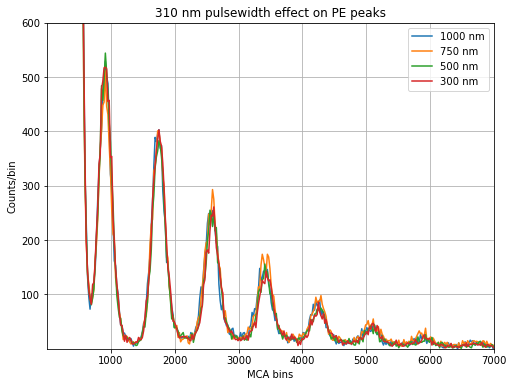

In [68]:
plt.figure(figsize=(8,6))
plt.title('310 nm pulsewidth effect on PE peaks')
plt.xticks(np.arange(0, 7001, 1000))
plt.grid(axis='both', which='both')
plt.xlabel('MCA bins')
plt.ylabel('Counts/bin')

for i,file in enumerate(file_list): 
    print("Working on file #%d: %s"%(i,file))
    file_parts = file.split("_")
    #print(file_parts)
    file_volts = float(file_parts[-3][:-2] ) # get voltage from filename
    file_wavelength = float(file_parts[-2]) # get wavelength from filename
    file_pulsewidth = float(file_parts[-1][:-3])
    
    if file_pulsewidth < 1100:
        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))
        b, c = rebin_histogram(bin_num, mca_hist, 20)

        plt.plot(b, c, label='%d nm'%(file_pulsewidth)) # add label to the plot
        plt.ylim(0.1, 600)
        plt.xlim(0.1, 7000)

# add legend
plt.legend()

plt.savefig('plots/310.png')

## 405nm

In [23]:
path_405 = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/405nm/' 
SRS_gain = 100 # gain on the SRS bandpass filter

file_list_405 = natsort.realsorted(glob.glob(path_405 + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list_405))

Found 8 files


Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/405nm/mca_keith_31.40OV_405_2000.h5
Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/405nm/mca_keith_31.40OV_405_1750.h5
Working on file #2: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/405nm/mca_keith_31.40OV_405_1500.h5
Working on file #3: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/405nm/mca_keith_31.40OV_405_1250.h5
Working on file #4: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/405nm/mca_keith_31.40OV_405_1000.h5
Working on file #5: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/405nm/mca_keith_31.40OV_405_750.h5
Working on file #6: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230317/pulse_width_effect/405nm/mca_keith_31.40OV_405_500.h5
Working on file #7: /gpfs/gibbs/project/dav

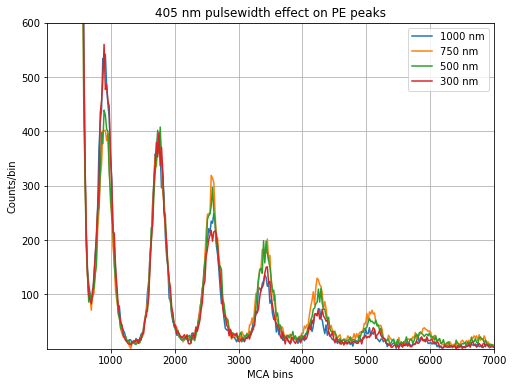

In [67]:
plt.figure(figsize=(8,6))
plt.title('405 nm pulsewidth effect on PE peaks')
plt.xticks(np.arange(0, 7001, 1000))
plt.grid(axis='both', which='both')
plt.xlabel('MCA bins')
plt.ylabel('Counts/bin')

for i,file in enumerate(file_list_405): 
    print("Working on file #%d: %s"%(i,file))
    file_parts = file.split("_")
    #print(file_parts)
    file_volts = float(file_parts[-3][:-2] ) # get voltage from filename
    file_wavelength = float(file_parts[-2]) # get wavelength from filename
    file_pulsewidth = float(file_parts[-1][:-3])
    
    if file_pulsewidth < 1100:
        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))
        b, c = rebin_histogram(bin_num, mca_hist, 20)
        
        plt.plot(b, c, label='%d nm'%(file_pulsewidth)) # add label to the plot
        plt.ylim(0.1, 600)
        plt.xlim(0.1, 7000)
        
        

# add legend
plt.legend() 

plt.savefig('plots/405_pulsewidth')
plt.show()

## Looking at data in vacuum of UV alone and with 405nm to mimic source

## Layering no, negative, and positive field

Found 40 files
Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step8/mca_keith_31.40OV_source_39.h5
Found 40 files
Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step8/mca_keith_31.40OV_310_39.h5
Found 40 files
Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step8/mca_keith_31.40OV_405_39.h5
Found 40 files
Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step9/mca_keith_31.40OV_source_39.h5
Found 39 files
Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step9/mca_keith_31.40OV_310_38.h5
Found 39 files
Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step9/mca_keith_31.40OV_405_38.h5
Found 40 files
Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_source_39.h5
Found 39 files
Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/

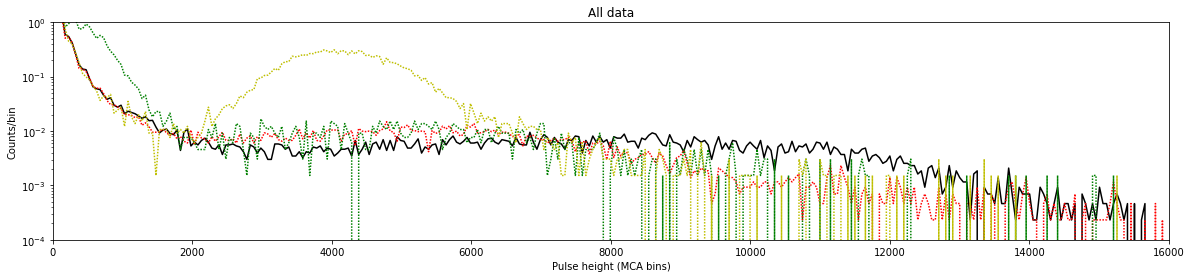

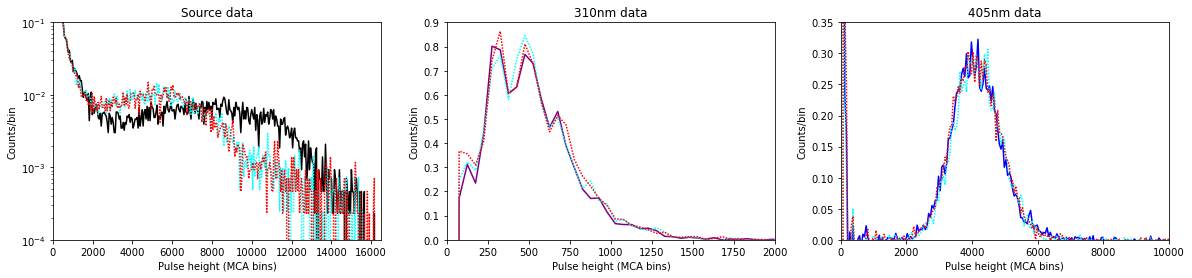

In [15]:
## Plot latest file
path_no = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step8/'
path_pos = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step9/'
path_neg = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/'

#linestyle_neg = ['']

type_list = ['source', '310', '405']
col_list = ['k', 'purple','b']
col_list_neg = ['r','g', 'y']
col_list_pos = ['slategrey', 'salmon', 'dodgerblue']
nfiles = 1
norm_range = [3000, 12000] ## set range to normalize counts (leave empty to not use)

ref_hist = 0
fig1 = plt.figure(figsize=(20,4))
#fig2 = plt.figure(figsize=(20,4))
fig2, axl = plt.subplots(1,3, figsize=(20,4))

# NO FIELD
for j,t in enumerate(type_list): #j: count, t: type
    file_list = natsort.realsorted(glob.glob(path_no + "*mca*%s*.h5"%t))
    print("Found %d files"%len(file_list))

    for i,file in enumerate(file_list[-nfiles:]): 
        print("Working on file #%d: %s"%(i,file))

        #file_parts = file.split("_")
        #file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))

        b, c = rebin_histogram(bin_num, mca_hist, 50)

        if(len(norm_range)==2):
            if(not t == "405"): 
                gpts = (b < norm_range[1]) & (b > norm_range[0])
                norm_fac = np.sum(c[gpts])
        else:
            norm_fac = 1

        if(t == "source"):
            ref_hist = c/norm_fac
        plt.figure(fig1.number)
        if(t == "source"):
            #axl[j].semilogy(b, c/norm_fac, color=col_list[j])
            plt.semilogy(b, c/norm_fac, color=col_list[j])
#         plt.plot(b, c/norm_fac, color=col_list[j])

        if(t == "310"):
            axl[j].plot(b, c/norm_fac - ref_hist, color=col_list[j])

        if(t == "405"):
            axl[j].plot(b, c/norm_fac - ref_hist, color=col_list[j])

        if(t == "source"):
            axl[j].semilogy(b, c/norm_fac, color=col_list[j])
# POS FIELD
for j,t in enumerate(type_list): #j: count, t: type
    file_list = natsort.realsorted(glob.glob(path_pos + "*mca*%s*.h5"%t))
    print("Found %d files"%len(file_list))

    for i,file in enumerate(file_list[-nfiles:]): 
        print("Working on file #%d: %s"%(i,file))

        #file_parts = file.split("_")
        #file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))

        b, c = rebin_histogram(bin_num, mca_hist, 50)

        if(len(norm_range)==2):
            if(not t == "405"): 
                gpts = (b < norm_range[1]) & (b > norm_range[0])
                norm_fac = np.sum(c[gpts])
        else:
            norm_fac = 1

        if(t == "source"):
            ref_hist = c/norm_fac
#         plt.figure(fig1.number)
# #         plt.semilogy(b, c/norm_fac, linestyle='dotted', dashes=(1, 1), color=col_list_pos[j])
#         plt.plot(b, c/norm_fac, linestyle='dotted', dashes=(1, 1), color=col_list_pos[j])
        
        if(t == "310"):
            axl[j].plot(b, c/norm_fac - ref_hist, linestyle='dotted', dashes=(1, 1), color='cyan')#col_list[j])

        if(t == "405"):
            axl[j].plot(b, c/norm_fac - ref_hist, linestyle='dotted', dashes=(1, 1), color='cyan')#color=col_list[j])

        if(t == "source"):
            axl[j].semilogy(b, c/norm_fac, linestyle='dotted', dashes=(1, 1), color='cyan')#color=col_list[j])

# NEG FIELD
for j,t in enumerate(type_list): #j: count, t: type
    file_list = natsort.realsorted(glob.glob(path_neg + "*mca*%s*.h5"%t))
    print("Found %d files"%len(file_list))

    for i,file in enumerate(file_list[-nfiles:]): 
        print("Working on file #%d: %s"%(i,file))

        #file_parts = file.split("_")
        #file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))

        b, c = rebin_histogram(bin_num, mca_hist, 50)

        if(len(norm_range)==2):
            if(not t == "405"): 
                gpts = (b < norm_range[1]) & (b > norm_range[0])
                norm_fac = np.sum(c[gpts])
        else:
            norm_fac = 1

        if(t == "source"):
            ref_hist = c/norm_fac
        plt.figure(fig1.number)
        plt.semilogy(b, c/norm_fac, linestyle='dashed', dashes=(1, 1), color=col_list_neg[j])
#         plt.plot(b, c/norm_fac, linestyle='dashed', dashes=(1, 1), color=col_list_neg[j])

        if(t == "310"):
            axl[j].plot(b, c/norm_fac - ref_hist, linestyle='dashed', dashes=(1, 1), color='r')#col_list[j])

        if(t == "405"):
            axl[j].plot(b, c/norm_fac - ref_hist, linestyle='dashed', dashes=(1, 1), color='r')#color=col_list[j])

        if(t == "source"):
            axl[j].semilogy(b, c/norm_fac, linestyle='dashed', dashes=(1, 1), color='r')#color=col_list[j])
            
plt.figure(fig1.number)
plt.xlabel('Pulse height (MCA bins)')
plt.ylabel('Counts/bin')
plt.title('All data')
plt.ylim(1e-4,1e0)
#plt.ylim(1e-4,0.025)
plt.xlim(0,16000)

plt.figure(fig2.number)
ax = axl[1]
ax.set_xlabel('Pulse height (MCA bins)')
ax.set_ylabel('Counts/bin')
ax.title.set_text('310nm data')
ax.set_ylim(0,0.9)
ax.set_xlim(0,2000)

ax = axl[2]
ax.set_xlabel('Pulse height (MCA bins)')
ax.set_ylabel('Counts/bin')
ax.title.set_text('405nm data')
ax.set_ylim(0,0.35)
ax.set_xlim(0,10000)

ax = axl[0]
ax.set_xlabel('Pulse height (MCA bins)')
ax.set_ylabel('Counts/bin')
ax.title.set_text('Source data')
ax.set_ylim(1e-4,1e-1)
ax.set_xlim(0,16500)

plt.show()

Found 40 files for type source
Found 39 files for type 310
Found 39 files for type 405
Found 40 files for type source
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_source_0.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_source_1.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_source_2.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_source_3.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_source_4.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_source_5.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_source_6.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321

Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_405_24.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_405_25.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_405_26.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_405_27.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_405_28.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_405_29.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_405_30.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_31.40OV_405_31.h5
Processing file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/mca_keith_3

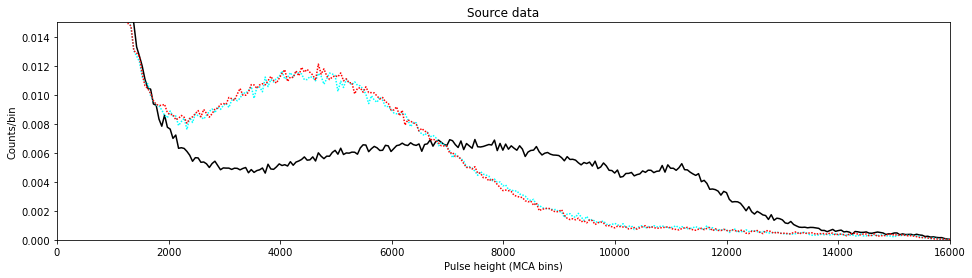

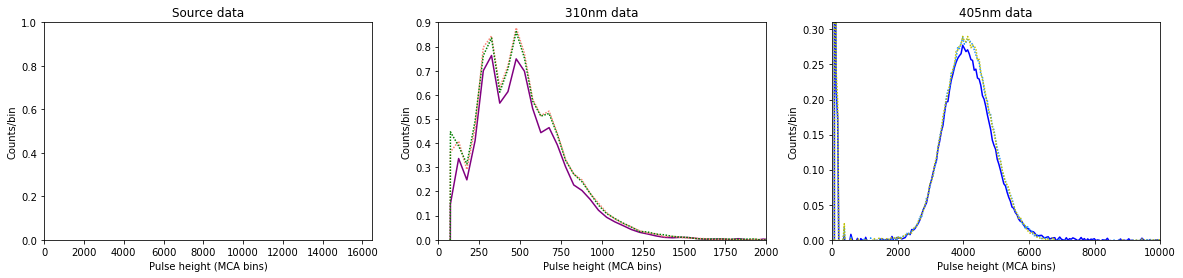

In [39]:
## Plot latest file
path_no = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step8/'
path_pos = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step9/'
path_neg = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step10/'

#linestyle_neg = ['']

type_list = ['source', '310', '405']
col_list = ['k', 'purple','b']
col_list_neg = ['r','g', 'y']
col_list_pos = ['slategrey', 'salmon', 'dodgerblue']
nfiles = 1
norm_range = [3000, 12000] ## set range to normalize counts (leave empty to not use)

ref_hist = 0
fig1 = plt.figure(figsize=(16,4))
#fig2 = plt.figure(figsize=(20,4))
fig2, axl = plt.subplots(1,3, figsize=(20,4))

# initialize an empty dictionary to hold the average data for each value of t
avg_data = {}

for j, t in enumerate(type_list): #j: count, t: type
    file_list = natsort.realsorted(glob.glob(path_no + "*mca*%s*.h5"%t))
    #print("Found %d files for type %s"%(len(file_list), t))

    # initialize an empty list to hold the data from each file
    data = []

    # loop over each file and extract the data
    for file in file_list:
        #print("Processing file %s"%file)

        with h5py.File(file, 'r') as f:  
            ch2 = f.get('ch2')
            for key in ch2.keys():
                mca_hist = np.array(ch2.get(key))
            bin_num = np.arange(len(mca_hist))

            b, c = rebin_histogram(bin_num, mca_hist, 50)

            if(len(norm_range)==2):
                if(not t == "405"): 
                    gpts = (b < norm_range[1]) & (b > norm_range[0])
                    norm_fac = np.sum(c[gpts])
            else:
                norm_fac = 1

            if(t == "source"):
                ref_hist = c/norm_fac

            # append the data to the list
            data.append(c/norm_fac)

    # convert the list to a numpy array and take the mean along the first axis (i.e., the files)
    mean_data = np.mean(np.array(data), axis=0)

    # add the mean data to the dictionary
    avg_data[t] = mean_data

    # plot the data
    plt.figure(fig1.number)
    if(t == "source"):
        plt.figure(fig1.number)
        plt.plot(b, mean_data, color=col_list[j])
    elif(t == "310" or t == "405"):
        axl[j].plot(b, mean_data - ref_hist, color=col_list[j])
        
# initialize an empty dictionary to hold the average data for each value of t
avg_data_pos = {}

for j, t in enumerate(type_list): #j: count, t: type
    file_list = natsort.realsorted(glob.glob(path_pos + "*mca*%s*.h5"%t))
    print("Found %d files for type %s"%(len(file_list), t))

    # initialize an empty list to hold the data from each file
    data = []

    # loop over each file and extract the data
    for file in file_list:
        #print("Processing file %s"%file)

        with h5py.File(file, 'r') as f:  
            ch2 = f.get('ch2')
            for key in ch2.keys():
                mca_hist = np.array(ch2.get(key))
            bin_num = np.arange(len(mca_hist))

            b, c = rebin_histogram(bin_num, mca_hist, 50)

            if(len(norm_range)==2):
                if(not t == "405"): 
                    gpts = (b < norm_range[1]) & (b > norm_range[0])
                    norm_fac = np.sum(c[gpts])
            else:
                norm_fac = 1

            if(t == "source"):
                ref_hist = c/norm_fac

            # append the data to the list
            data.append(c/norm_fac)

    # convert the list to a numpy array and take the mean along the first axis (i.e., the files)
    mean_data = np.mean(np.array(data), axis=0)

    # add the mean data to the dictionary
    avg_data_pos[t] = mean_data

    # plot the data
    #plt.figure(fig1.number)
    if(t == "source"):
        plt.figure(fig1.number)
        plt.plot(b, mean_data, linestyle='dotted', dashes=(1, 1), color='cyan')#col_list_pos[j])
    elif(t == "310" or t == "405"):
        axl[j].plot(b, mean_data - ref_hist, linestyle='dotted', dashes=(1, 1),color=col_list_pos[j])
        
# initialize an empty dictionary to hold the average data for each value of t
avg_data_neg = {}

for j, t in enumerate(type_list): #j: count, t: type
    file_list = natsort.realsorted(glob.glob(path_neg + "*mca*%s*.h5"%t))
    print("Found %d files for type %s"%(len(file_list), t))

    # initialize an empty list to hold the data from each file
    data = []

    # loop over each file and extract the data
    for file in file_list:
        print("Processing file %s"%file)

        with h5py.File(file, 'r') as f:  
            ch2 = f.get('ch2')
            for key in ch2.keys():
                mca_hist = np.array(ch2.get(key))
            bin_num = np.arange(len(mca_hist))

            b, c = rebin_histogram(bin_num, mca_hist, 50)

            if(len(norm_range)==2):
                if(not t == "405"): 
                    gpts = (b < norm_range[1]) & (b > norm_range[0])
                    norm_fac = np.sum(c[gpts])
            else:
                norm_fac = 1

            if(t == "source"):
                ref_hist = c/norm_fac

            # append the data to the list
            data.append(c/norm_fac)

    # convert the list to a numpy array and take the mean along the first axis (i.e., the files)
    mean_data = np.mean(np.array(data), axis=0)

    # add the mean data to the dictionary
    avg_data_neg[t] = mean_data

    # plot the data
    #plt.figure(fig1.number)
    if(t == "source"):
        plt.figure(fig1.number)
        plt.plot(b, mean_data, linestyle='dashed', dashes=(1, 1), color='r')#col_list_neg[j])
    elif(t == "310" or t == "405"):
        axl[j].plot(b, mean_data - ref_hist, linestyle='dashed', dashes=(1, 1),color=col_list_neg[j])

print(avg_data)
print(avg_data_pos)
        
plt.figure(fig1.number)
plt.xlabel('Pulse height (MCA bins)')
plt.ylabel('Counts/bin')
plt.title('Source data')
#plt.ylim(1e-4,1e0)
plt.ylim(0,0.015)
plt.xlim(0,16000)

plt.figure(fig2.number)
ax = axl[1]
ax.set_xlabel('Pulse height (MCA bins)')
ax.set_ylabel('Counts/bin')
ax.title.set_text('310nm data')
ax.set_ylim(0,0.9)
ax.set_xlim(0,2000)

ax = axl[2]
ax.set_xlabel('Pulse height (MCA bins)')
ax.set_ylabel('Counts/bin')
ax.title.set_text('405nm data')
ax.set_ylim(0,0.31)
ax.set_xlim(0,10000)

ax = axl[0]
ax.set_xlabel('Pulse height (MCA bins)')
ax.set_ylabel('Counts/bin')
ax.title.set_text('Source data')
#ax.set_ylim(1e-4,1e-1)
ax.set_xlim(0,16500)

plt.show()

## Looking at old data

In [49]:
path_pos = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20221007/Step14/' 
SRS_gain = 100 # gain on the SRS bandpass filter

file_list_pos = natsort.realsorted(glob.glob(path_pos + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list_pos))

Found 22 files


In [50]:
path_no = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20221007/Step9_take2/'
path_pos = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20221007/Step14/'
path_neg = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20221007/Step12/'

Found 22 files
Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20221007/Step14/mca_keith_31.40OV_20.h5
Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20221007/Step14/mca_keith_31.40OV_21.h5


/gpfs/gibbs/project/david_moore/mpw46/conda_envs/new_env1/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


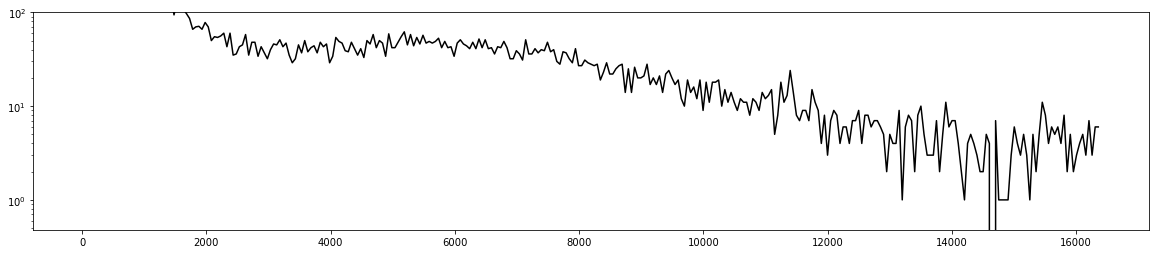

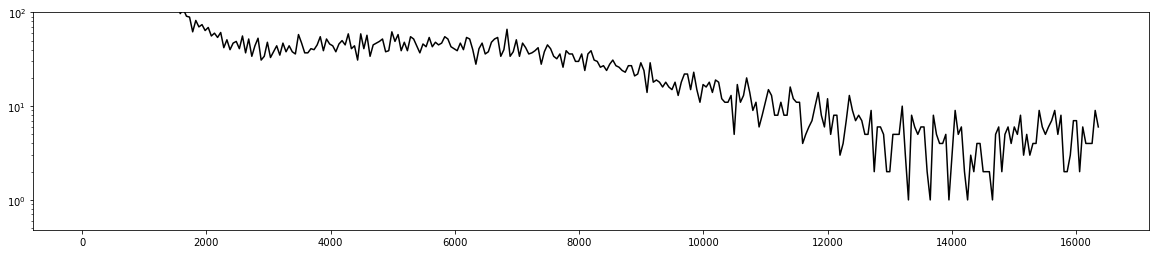

In [53]:
## Plot latest file
#path = r"C:/Data/20221007/Step14/"
file_list = natsort.realsorted(glob.glob(path_pos + "mca*.h5"))
print("Found %d files"%len(file_list))
for i,file in enumerate(file_list[-2:]): #last 2 files
    print("Working on file #%d: %s"%(i,file))
    
    file_parts = file.split("_")
    file_volts = float( file_parts[-2][:-2] ) # get voltage from filename
    
    f = h5py.File(file, 'r')
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    
    b,c = rebin_histogram(bin_num, mca_hist, 50)
    
    plt.figure(figsize=(20,4))
    plt.semilogy(b, c, 'k')
    plt.ylim(0,100)
    #plt.xlim(0,2500)
plt.show()